In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import plotly.offline as py
py.init_notebook_mode(connected=True)
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
import plotly.tools as tls

import time
import datetime

import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import gc

import logging

logging.basicConfig(filename='log.txt',level=logging.DEBUG, format='%(asctime)s %(message)s')

pd.set_option('display.max_columns', 500)
pd.set_option('max_rows', 100)

In [2]:
# A function to use the best available data type in order to
# conserve memory
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage(deep=True).sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage(deep=True).sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

## Load Data
https://www.kaggle.com/theoviel/load-the-totality-of-the-data

In [3]:
dtypes = {
        'MachineIdentifier':                                    'category',
        'ProductName':                                          'category',
        'EngineVersion':                                        'category',
        'AppVersion':                                           'category',
        'AvSigVersion':                                         'category',
        'IsBeta':                                               'int8',
        'RtpStateBitfield':                                     'float16',
        'IsSxsPassiveMode':                                     'int8',
        'DefaultBrowsersIdentifier':                            'float32',
        'AVProductStatesIdentifier':                            'float32',
        'AVProductsInstalled':                                  'float16',
        'AVProductsEnabled':                                    'float16',
        'HasTpm':                                               'int8',
        'CountryIdentifier':                                    'int16',
        'CityIdentifier':                                       'float32',
        'OrganizationIdentifier':                               'float16',
        'GeoNameIdentifier':                                    'float16',
        'LocaleEnglishNameIdentifier':                          'int16',
        'Platform':                                             'category',
        'Processor':                                            'category',
        'OsVer':                                                'category',
        'OsBuild':                                              'int16',
        'OsSuite':                                              'int16',
        'OsPlatformSubRelease':                                 'category',
        'OsBuildLab':                                           'category',
        'SkuEdition':                                           'category',
        'IsProtected':                                          'float16',
        'AutoSampleOptIn':                                      'int8',
        'PuaMode':                                              'category',
        'SMode':                                                'float16',
        'IeVerIdentifier':                                      'float16',
        'SmartScreen':                                          'category',
        'Firewall':                                             'float16',
        'UacLuaenable':                                         'float64', # was 'float32'
        'Census_MDC2FormFactor':                                'category',
        'Census_DeviceFamily':                                  'category',
        'Census_OEMNameIdentifier':                             'float32', # was 'float16'
        'Census_OEMModelIdentifier':                            'float32',
        'Census_ProcessorCoreCount':                            'float16',
        'Census_ProcessorManufacturerIdentifier':               'float16',
        'Census_ProcessorModelIdentifier':                      'float32', # was 'float16'
        'Census_ProcessorClass':                                'category',
        'Census_PrimaryDiskTotalCapacity':                      'float64', # was 'float32'
        'Census_PrimaryDiskTypeName':                           'category',
        'Census_SystemVolumeTotalCapacity':                     'float64', # was 'float32'
        'Census_HasOpticalDiskDrive':                           'int8',
        'Census_TotalPhysicalRAM':                              'float32',
        'Census_ChassisTypeName':                               'category',
        'Census_InternalPrimaryDiagonalDisplaySizeInInches':    'float32', # was 'float16'
        'Census_InternalPrimaryDisplayResolutionHorizontal':    'float32', # was 'float16'
        'Census_InternalPrimaryDisplayResolutionVertical':      'float32', # was 'float16'
        'Census_PowerPlatformRoleName':                         'category',
        'Census_InternalBatteryType':                           'category',
        'Census_InternalBatteryNumberOfCharges':                'float64', # was 'float32'
        'Census_OSVersion':                                     'category',
        'Census_OSArchitecture':                                'category',
        'Census_OSBranch':                                      'category',
        'Census_OSBuildNumber':                                 'int16',
        'Census_OSBuildRevision':                               'int32',
        'Census_OSEdition':                                     'category',
        'Census_OSSkuName':                                     'category',
        'Census_OSInstallTypeName':                             'category',
        'Census_OSInstallLanguageIdentifier':                   'float16',
        'Census_OSUILocaleIdentifier':                          'int16',
        'Census_OSWUAutoUpdateOptionsName':                     'category',
        'Census_IsPortableOperatingSystem':                     'int8',
        'Census_GenuineStateName':                              'category',
        'Census_ActivationChannel':                             'category',
        'Census_IsFlightingInternal':                           'float16',
        'Census_IsFlightsDisabled':                             'float16',
        'Census_FlightRing':                                    'category',
        'Census_ThresholdOptIn':                                'float16',
        'Census_FirmwareManufacturerIdentifier':                'float16',
        'Census_FirmwareVersionIdentifier':                     'float32',
        'Census_IsSecureBootEnabled':                           'int8',
        'Census_IsWIMBootEnabled':                              'float16',
        'Census_IsVirtualDevice':                               'float16',
        'Census_IsTouchEnabled':                                'int8',
        'Census_IsPenCapable':                                  'int8',
        'Census_IsAlwaysOnAlwaysConnectedCapable':              'float16',
        'Wdft_IsGamer':                                         'float16',
        'Wdft_RegionIdentifier':                                'float16',
        'HasDetections':                                        'int8'
        }

In [4]:
%%time
train = pd.read_csv('train.csv', dtype=dtypes)

Wall time: 6min 16s


In [5]:
%%time
train = reduce_mem_usage(train)

Mem. usage decreased to 2371.54 Mb (9.1% reduction)
Wall time: 16.2 s


In [6]:
train.shape

(8921483, 83)

In [7]:
train['HasDetections'].value_counts()

0    4462591
1    4458892
Name: HasDetections, dtype: int64

We can see that the target variable is balacnced, which is nice.

### Preliminary Analysis

As we can see, there is a very large number of columns, so we must do some analysis in order to determine whether we can drop some of them. 

In [8]:
%%time
stats = []
for col in train.columns:
    stats.append((col, train[col].nunique(), train[col].isnull().sum() * 100 / train.shape[0], train[col].value_counts(normalize=True, dropna=False).values[0] * 100, train[col].dtype))
    
stats_df = pd.DataFrame(stats, columns=['Feature', 'Unique Values', 'Missing Values (%)', 'Values in the Biggest Category (%)', 'type'])

Wall time: 51.2 s


In [9]:
stats_df.sort_values('Missing Values (%)', ascending=False)

,Feature,Unique Values,Missing Values (%),Values in the Biggest Category (%),type
28,PuaMode,2,99.974119,99.974119,category
41,Census_ProcessorClass,3,99.589407,99.589407,category
8,DefaultBrowsersIdentifier,1730,95.141637,95.141637,float16
68,Census_IsFlightingInternal,2,83.044030,83.044030,float16
52,Census_InternalBatteryType,78,71.046809,71.046809,category
71,Census_ThresholdOptIn,2,63.524472,63.524472,float16
75,Census_IsWIMBootEnabled,2,63.439038,63.439038,float16
31,SmartScreen,21,35.610795,48.379658,category
15,OrganizationIdentifier,49,30.841487,47.037662,float16
29,SMode,2,6.027686,93.928812,float16


In [10]:
stats_df.sort_values('Values in the Biggest Category (%)', ascending=False)

,Feature,Unique Values,Missing Values (%),Values in the Biggest Category (%),type
5,IsBeta,2,0.000000,99.999249,int8
27,AutoSampleOptIn,2,0.000000,99.997108,int8
28,PuaMode,2,99.974119,99.974119,category
65,Census_IsPortableOperatingSystem,2,0.000000,99.945480,int8
35,Census_DeviceFamily,3,0.000000,99.838256,category
41,Census_ProcessorClass,3,99.589407,99.589407,category
33,UacLuaenable,11,0.121482,99.271803,float32
76,Census_IsVirtualDevice,2,0.178816,99.118499,float16
1,ProductName,6,0.000000,98.935569,category
12,HasTpm,2,0.000000,98.797106,int8


We can see that there are some columns with a lot of missing data and some that most of their values are in the same category. These columns should be dropped.<br>
Lets find a way to automate this process:

In [11]:
%%time
usable_cols = list(train.columns)
for col in train.columns:
    skewness = train[col].value_counts(normalize=True, dropna=False).values[0]
    miss = train[col].isnull().sum()/train.shape[0]
    if (skewness > 0.9) or (miss > 0.95):
        usable_cols.remove(col)

Wall time: 30 s


Also, as seen in the analysis by https://www.kaggle.com/jiegeng94/everyone-do-this-at-the-beginning, some variables highly correlate, so one of these can be dropped.

In [12]:
print(train.Census_OSBuildNumber.nunique())
print(train.Census_OSVersion.nunique())

165
469


In [13]:
print(train.EngineVersion.nunique())
print(train.AvSigVersion.nunique())

70
8531


In [14]:
corr_remove = []
corr_remove.append('Census_OSSkuName')
corr_remove.append('Census_OSInstallLanguageIdentifier')
corr_remove.append('Census_OSBuildNumber')
corr_remove.append('EngineVersion')

In [15]:
%%time
for col in usable_cols:
    if col in corr_remove:
        usable_cols.remove(col)

Wall time: 0 ns


In [16]:
%%time
train = train[usable_cols]

Wall time: 2.43 s


#### Load Test

In [17]:
%%time
test_dtypes = {k: v for k, v in dtypes.items() if k in usable_cols}
test = pd.read_csv('test.csv', dtype=test_dtypes, usecols=usable_cols[:-1])

Wall time: 4min 10s


In [18]:
%%time
test = reduce_mem_usage(test)

Mem. usage decreased to 1789.03 Mb (8.4% reduction)
Wall time: 11.2 s


In [19]:
test.shape

(7853253, 52)

In [20]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7853253 entries, 0 to 7853252
Data columns (total 52 columns):
MachineIdentifier                                    category
AppVersion                                           category
AvSigVersion                                         category
AVProductStatesIdentifier                            float32
AVProductsInstalled                                  float16
CountryIdentifier                                    int16
CityIdentifier                                       float32
OrganizationIdentifier                               float16
GeoNameIdentifier                                    float16
LocaleEnglishNameIdentifier                          int16
OsBuild                                              int16
OsSuite                                              int16
OsPlatformSubRelease                                 category
OsBuildLab                                           category
SkuEdition                          

In [21]:
train.head(10)

,MachineIdentifier,AppVersion,AvSigVersion,AVProductStatesIdentifier,AVProductsInstalled,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,OsBuild,OsSuite,OsPlatformSubRelease,OsBuildLab,SkuEdition,IeVerIdentifier,SmartScreen,Census_MDC2FormFactor,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,Census_ProcessorModelIdentifier,Census_PrimaryDiskTotalCapacity,Census_PrimaryDiskTypeName,Census_SystemVolumeTotalCapacity,Census_TotalPhysicalRAM,Census_ChassisTypeName,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_PowerPlatformRoleName,Census_InternalBatteryType,Census_InternalBatteryNumberOfCharges,Census_OSVersion,Census_OSBranch,Census_OSBuildRevision,Census_OSEdition,Census_OSInstallTypeName,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_GenuineStateName,Census_ActivationChannel,Census_IsFlightingInternal,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsTouchEnabled,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
0,0000028988387b115f69f31a3bf04f09,4.18.1807.18075,1.273.1735.0,53447.0,1.0,29,128035.0,18.0,35.0,171,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,137.0,NaN,Desktop,2668.0,9124.0,4.0,5.0,2340.0,476940.0,HDD,299451.0,4096.0,Desktop,18.906250,1440.0,900.0,Desktop,NaN,4.294967e+09,10.0.17134.165,rs4_release,165,Professional,UUPUpgrade,119,UNKNOWN,IS_GENUINE,Retail,NaN,NaN,628.0,36144.0,0,NaN,0,0.0,10.0,0
1,000007535c3f730efa9ea0b7ef1bd645,4.13.17134.1,1.263.48.0,53447.0,1.0,93,1482.0,18.0,119.0,64,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,137.0,NaN,Notebook,2668.0,91656.0,4.0,5.0,2404.0,476940.0,HDD,102385.0,4096.0,Notebook,13.898438,1366.0,768.0,Mobile,NaN,1.000000e+00,10.0.17134.1,rs4_release,1,Professional,IBSClean,31,UNKNOWN,OFFLINE,Retail,NaN,NaN,628.0,57858.0,0,NaN,0,0.0,8.0,0
2,000007905a28d863f6d0d597892cd692,4.18.1807.18075,1.273.1341.0,53447.0,1.0,86,153579.0,18.0,64.0,49,17134,768,rs4,17134.1.amd64fre.rs4_release.180410-1804,Home,137.0,RequireAdmin,Desktop,4908.0,317701.0,4.0,5.0,1972.0,114473.0,SSD,113907.0,4096.0,Desktop,21.500000,1920.0,1080.0,Desktop,NaN,4.294967e+09,10.0.17134.165,rs4_release,165,Core,UUPUpgrade,30,FullAuto,IS_GENUINE,OEM:NONSLP,NaN,NaN,142.0,52682.0,0,NaN,0,0.0,3.0,0
3,00000b11598a75ea8ba1beea8459149f,4.18.1807.18075,1.273.1527.0,53447.0,1.0,88,20710.0,NaN,117.0,115,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,137.0,ExistsNotSet,Desktop,1443.0,275890.0,4.0,5.0,2272.0,238475.0,UNKNOWN,227116.0,4096.0,MiniTower,18.500000,1366.0,768.0,Desktop,NaN,4.294967e+09,10.0.17134.228,rs4_release,228,Professional,UUPUpgrade,64,FullAuto,IS_GENUINE,OEM:NONSLP,NaN,NaN,355.0,20050.0,0,NaN,0,0.0,3.0,1
4,000014a5f00daa18e76b81417eeb99fc,4.18.1807.18075,1.273.1379.0,53447.0,1.0,18,37376.0,NaN,277.0,75,17134,768,rs4,17134.1.amd64fre.rs4_release.180410-1804,Home,137.0,RequireAdmin,Notebook,1443.0,331929.0,4.0,5.0,2500.0,476940.0,HDD,101900.0,6144.0,Portable,14.000000,1366.0,768.0,Mobile,lion,0.000000e+00,10.0.17134.191,rs4_release,191,Core,Update,31,FullAuto,IS_GENUINE,Retail,0.0,0.0,355.0,19844.0,0,0.0,0,0.0,1.0,1
5,000016191b897145d069102325cab760,4.18.1807.18075,1.273.1094.0,53447.0,1.0,97,13598.0,27.0,126.0,124,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,137.0,RequireAdmin,Desktop,3800.0,340727.0,2.0,5.0,4324.0,114473.0,SSD,113671.0,8192.0,Desktop,21.500000,1920.0,1080.0,Desktop,NaN,4.294967e+09,10.0.17134.165,rs4_release,165,Professional,UUPUpgrade,72,FullAuto,IS_GENUINE,Retail,0.0,0.0,93.0,51039.0,0,0.0,0,0.0,15.0,1
6,0000161e8abf8d8b89c5ab8787fd712b,4.18.1807.18075,1.273.845.0,43927.0,2.0,78,81215.0,NaN,89.0,88,17134,768,rs4,17134.1.amd64fre.rs4_release.180410-1804,Home,137.0,NaN,Notebook,3800.0,207

## EDA

Functions and ideas from https://www.kaggle.com/artgor/is-this-malware-eda-fe-and-lgb-updated and https://www.kaggle.com/youhanlee/my-eda-i-want-to-see-all

In [22]:
#https://www.kaggle.com/artgor/is-this-malware-eda-fe-and-lgb-updated
# function to plot data
def plot_categorical_feature(col, only_bars=False, top_n=10, by_touch=False):
    top_n = top_n if train[col].nunique() > top_n else train[col].nunique()
    print(f"{col} has {train[col].nunique()} unique values and type: {train[col].dtype}.")
    print(train[col].value_counts(normalize=True, dropna=False).head())
    if not by_touch:
        if not only_bars:
            df = train.groupby([col]).agg({'HasDetections': ['count', 'mean']})
            df = df.sort_values(('HasDetections', 'count'), ascending=False).head(top_n).sort_index()
            data = [go.Bar(x=df.index, y=df['HasDetections']['count'].values, name='counts'),
                    go.Scatter(x=df.index, y=df['HasDetections']['mean'], name='Detections rate', yaxis='y2')]

            layout = go.Layout(dict(title = f"Counts of {col} by top-{top_n} categories and mean target value",
                                xaxis = dict(title = f'{col}',
                                             showgrid=False,
                                             zeroline=False,
                                             showline=False,),
                                yaxis = dict(title = 'Counts',
                                             showgrid=False,
                                             zeroline=False,
                                             showline=False,),
                                yaxis2=dict(title='Detections rate', overlaying='y', side='right')),
                           legend=dict(orientation="v"))

        else:
            top_cat = list(train[col].value_counts(dropna=False).index[:top_n])
            df0 = train.loc[(train[col].isin(top_cat)) & (train['HasDetections'] == 1), col].value_counts().head(10).sort_index()
            df1 = train.loc[(train[col].isin(top_cat)) & (train['HasDetections'] == 0), col].value_counts().head(10).sort_index()
            data = [go.Bar(x=df0.index, y=df0.values, name='Has Detections'),
                    go.Bar(x=df1.index, y=df1.values, name='No Detections')]

            layout = go.Layout(dict(title = f"Counts of {col} by top-{top_n} categories",
                                xaxis = dict(title = f'{col}',
                                             showgrid=False,
                                             zeroline=False,
                                             showline=False,),
                                yaxis = dict(title = 'Counts',
                                             showgrid=False,
                                             zeroline=False,
                                             showline=False,),
                                ),
                           legend=dict(orientation="v"), barmode='group')
        
        py.iplot(dict(data=data, layout=layout))
        
    else:
        top_n = 10
        top_cat = list(train[col].value_counts(dropna=False).index[:top_n])
        df = train.loc[train[col].isin(top_cat)]

        df1 = train.loc[train['Census_IsTouchEnabled'] == 1]
        df0 = train.loc[train['Census_IsTouchEnabled'] == 0]

        df0_ = df0.groupby([col]).agg({'HasDetections': ['count', 'mean']})
        df0_ = df0_.sort_values(('HasDetections', 'count'), ascending=False).head(top_n).sort_index()
        df1_ = df1.groupby([col]).agg({'HasDetections': ['count', 'mean']})
        df1_ = df1_.sort_values(('HasDetections', 'count'), ascending=False).head(top_n).sort_index()
        data1 = [go.Bar(x=df0_.index, y=df0_['HasDetections']['count'].values, name='Nontouch device counts'),
                go.Scatter(x=df0_.index, y=df0_['HasDetections']['mean'], name='Detections rate for nontouch devices', yaxis='y2')]
        data2 = [go.Bar(x=df1_.index, y=df1_['HasDetections']['count'].values, name='Touch device counts'),
                go.Scatter(x=df1_.index, y=df1_['HasDetections']['mean'], name='Detections rate for touch devices', yaxis='y2')]

        layout = go.Layout(dict(title = f"Counts of {col} by top-{top_n} categories for nontouch devices",
                            xaxis = dict(title = f'{col}',
                                         showgrid=False,
                                         zeroline=False,
                                         showline=False,
                                         type='category'),
                            yaxis = dict(title = 'Counts',
                                         showgrid=False,
                                         zeroline=False,
                                         showline=False,),
                                    yaxis2=dict(title='Detections rate', overlaying='y', side='right'),
                            ),
                       legend=dict(orientation="v"), barmode='group')

        py.iplot(dict(data=data1, layout=layout))
        layout['title'] = f"Counts of {col} by top-{top_n} categories for touch devices"
        py.iplot(dict(data=data2, layout=layout))

In [23]:
plot_categorical_feature('OsBuild', True, 10)

OsBuild has 76 unique values and type: int16.
17134    0.438887
16299    0.280635
15063    0.087460
14393    0.081917
10586    0.046136
Name: OsBuild, dtype: float64


In [24]:
plot_categorical_feature('OsSuite', True, 5)

OsSuite has 14 unique values and type: int16.
768    0.623289
256    0.375078
272    0.001355
400    0.000089
16     0.000082
Name: OsSuite, dtype: float64


In [25]:
plot_categorical_feature('Census_ProcessorManufacturerIdentifier', True, 5)

Census_ProcessorManufacturerIdentifier has 7 unique values and type: float16.
 5.0     0.878701
 1.0     0.116605
NaN      0.004631
 10.0    0.000038
 3.0     0.000024
Name: Census_ProcessorManufacturerIdentifier, dtype: float64


In [26]:
plot_categorical_feature('Census_IsFlightingInternal', True, 2)

Census_IsFlightingInternal has 2 unique values and type: float16.
NaN     0.830440
 0.0    0.169557
 1.0    0.000002
Name: Census_IsFlightingInternal, dtype: float64


In [27]:
plot_categorical_feature('Census_ThresholdOptIn', True, 2)

Census_ThresholdOptIn has 2 unique values and type: float16.
NaN     0.635245
 0.0    0.364664
 1.0    0.000091
Name: Census_ThresholdOptIn, dtype: float64


## Preprocessing

After some EDA, we can see that we need to do the following processing:

### Handle Missing Values

In [28]:
def handleMV(df):
    # Zero
    df['AVProductStatesIdentifier'] = df['AVProductStatesIdentifier'].fillna(0)
    df['CityIdentifier'] = df['CityIdentifier'].fillna(0)
    df['OrganizationIdentifier'] = df['OrganizationIdentifier'].fillna(0)
    df['GeoNameIdentifier'] = df['GeoNameIdentifier'].fillna(0)
    df['Census_OEMNameIdentifier'] = df['Census_OEMNameIdentifier'].fillna(0)
    df['Census_OEMModelIdentifier'] = df['Census_OEMModelIdentifier'].fillna(0)
    df['Census_ProcessorModelIdentifier'] = df['Census_ProcessorModelIdentifier'].fillna(0)    
    df['Census_InternalPrimaryDiagonalDisplaySizeInInches'] = df['Census_InternalPrimaryDiagonalDisplaySizeInInches'].fillna(0)
    df['Census_InternalPrimaryDisplayResolutionHorizontal'] = df['Census_InternalPrimaryDisplayResolutionHorizontal'].fillna(0)
    df['Census_InternalPrimaryDisplayResolutionVertical'] = df['Census_InternalPrimaryDisplayResolutionVertical'].fillna(0)
    #df['Census_OSInstallLanguageIdentifier'] = df['Census_OSInstallLanguageIdentifier'].fillna(0)
    df['Census_OSUILocaleIdentifier'] = df['Census_OSUILocaleIdentifier'].fillna(0)
    df['Census_FirmwareManufacturerIdentifier'] = df['Census_FirmwareManufacturerIdentifier'].fillna(0)
    df['Census_FirmwareVersionIdentifier'] = df['Census_FirmwareVersionIdentifier'].fillna(0)
    df['Wdft_RegionIdentifier'] = df['Wdft_RegionIdentifier'].fillna(0)
    
    df['SmartScreen'] = df['SmartScreen'].fillna('ExistsNotSet')
    df['Census_PrimaryDiskTypeName'] = df['Census_PrimaryDiskTypeName'].fillna('UNKNOWN')
    df['Census_ChassisTypeName'] = df['Census_ChassisTypeName'].fillna('UNKNOWN')
    df['Census_PowerPlatformRoleName'] = df['Census_PowerPlatformRoleName'].fillna('UNKNOWN')   
    
    # Census_InternalBatteryNumberOfCharges left as NaN
    
    # One instead of Zero to better balance the categories
    df['Census_IsFlightingInternal'] = df['Census_IsFlightingInternal'].fillna(1)
    df['Census_ThresholdOptIn'] = df['Census_ThresholdOptIn'].fillna(1)
    df['Census_IsWIMBootEnabled'] = df['Census_IsWIMBootEnabled'].fillna(1)
    
    # Mean Value
    df['AVProductsInstalled'] = df['AVProductsInstalled'].fillna(df['AVProductsInstalled'].mean())
    df['Census_ProcessorCoreCount'] = df['Census_ProcessorCoreCount'].fillna(df['Census_ProcessorCoreCount'].mean())
    df['Census_PrimaryDiskTotalCapacity'] = df['Census_PrimaryDiskTotalCapacity'].fillna(df['Census_PrimaryDiskTotalCapacity'].mean())
    df['Census_SystemVolumeTotalCapacity'] = df['Census_SystemVolumeTotalCapacity'].fillna(df['Census_SystemVolumeTotalCapacity'].mean())
    df['Census_TotalPhysicalRAM'] = df['Census_TotalPhysicalRAM'].fillna(df['Census_TotalPhysicalRAM'].mean())

    # Most Common Value
    df['IeVerIdentifier'] = df['IeVerIdentifier'].fillna(137)
    df['Census_ProcessorManufacturerIdentifier'] = df['Census_ProcessorManufacturerIdentifier'].fillna(5)
    df['Wdft_IsGamer'] = df['Wdft_IsGamer'].fillna(0)
    
    return df

In [29]:
train['OsBuildLab'] = train['OsBuildLab'].cat.add_categories(['0.0.0.0.0-0'])
train['OsBuildLab'] = train['OsBuildLab'].fillna('0.0.0.0.0-0')
test['OsBuildLab'] = test['OsBuildLab'].cat.add_categories(['0.0.0.0.0-0'])
test['OsBuildLab'] = test['OsBuildLab'].fillna('0.0.0.0.0-0')
train['Census_InternalBatteryType'] = train['Census_InternalBatteryType'].cat.add_categories(['UNKNOWN'])
train['Census_InternalBatteryType'] = train['Census_InternalBatteryType'].fillna('UNKNOWN')   
test['Census_InternalBatteryType'] = test['Census_InternalBatteryType'].cat.add_categories(['UNKNOWN'])
test['Census_InternalBatteryType'] = test['Census_InternalBatteryType'].fillna('UNKNOWN')   

In [30]:
%%time
train = handleMV(train)

Wall time: 3.52 s


In [31]:
%%time
test = handleMV(test)

Wall time: 2.19 s


### Replacing Numerical With Categorical

Based on the EDA on https://www.kaggle.com/artgor/is-this-malware-eda-fe-and-lgb-updated and https://www.kaggle.com/youhanlee/my-eda-i-want-to-see-all, we can easily see that some values are categorical, although they are imported as numerical.

In [32]:
def categorize(df):
    df['AVProductStatesIdentifier'] = df['AVProductStatesIdentifier'].astype('category')
    df['AVProductsInstalled'] = df['AVProductsInstalled'].astype('category')
    df['CountryIdentifier'] = df['CountryIdentifier'].astype('category')
    df['CityIdentifier'] = df['CityIdentifier'].astype('category')
    df['OrganizationIdentifier'] = df['OrganizationIdentifier'].astype('category')
    df['GeoNameIdentifier'] = df['GeoNameIdentifier'].astype('category')
    df['LocaleEnglishNameIdentifier'] = df['LocaleEnglishNameIdentifier'].astype('category')
    df['OsBuild'] = df['OsBuild'].astype('category')
    df['OsSuite'] = df['OsSuite'].astype('category')
    df['IeVerIdentifier'] = df['IeVerIdentifier'].astype('category')
    df['Census_OEMNameIdentifier'] = df['Census_OEMNameIdentifier'].astype('category')
    df['Census_OEMModelIdentifier'] = df['Census_OEMModelIdentifier'].astype('category')
    df['Census_ProcessorCoreCount'] = df['Census_ProcessorCoreCount'].astype('category')
    df['Census_ProcessorManufacturerIdentifier'] = df['Census_ProcessorManufacturerIdentifier'].astype('category')
    df['Census_ProcessorModelIdentifier'] = df['Census_ProcessorModelIdentifier'].astype('category')
    df['Census_TotalPhysicalRAM'] = df['Census_TotalPhysicalRAM'].astype('category')
    df['Census_InternalBatteryNumberOfCharges'] = df['Census_InternalBatteryNumberOfCharges'].astype('category')
    #df['Census_OSBuildNumber'] = df['Census_OSBuildNumber'].astype('category')
    df['Census_OSBuildRevision'] = df['Census_OSBuildRevision'].astype('category')
    #df['Census_OSInstallLanguageIdentifier'] = df['Census_OSInstallLanguageIdentifier'].astype('category')
    df['Census_OSUILocaleIdentifier'] = df['Census_OSUILocaleIdentifier'].astype('category')
    df['Census_FirmwareManufacturerIdentifier'] = df['Census_FirmwareManufacturerIdentifier'].astype('category')
    df['Census_FirmwareVersionIdentifier'] = df['Census_FirmwareVersionIdentifier'].astype('category')
    df['Census_IsSecureBootEnabled'] = df['Census_IsSecureBootEnabled'].astype('category')
    df['Census_IsWIMBootEnabled'] = df['Census_IsWIMBootEnabled'].astype('category')
    df['Census_IsTouchEnabled'] = df['Census_IsTouchEnabled'].astype('category')
    df['Census_IsFlightingInternal'] = df['Census_IsFlightingInternal'].astype('category')
    df['Census_ThresholdOptIn'] = df['Census_ThresholdOptIn'].astype('category')
    df['Wdft_IsGamer'] = df['Wdft_IsGamer'].astype('category')
    df['Wdft_RegionIdentifier'] = df['Wdft_RegionIdentifier'].astype('category')
    
    return df

In [33]:
%%time
train = categorize(train)

Wall time: 12.8 s


In [34]:
%%time
test = categorize(test)

Wall time: 10.6 s


In [35]:
%%time
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Mem. usage decreased to 1871.07 Mb (0.0% reduction)
Mem. usage decreased to 1678.24 Mb (0.0% reduction)
Wall time: 6.62 s


In [36]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8921483 entries, 0 to 8921482
Data columns (total 53 columns):
MachineIdentifier                                    category
AppVersion                                           category
AvSigVersion                                         category
AVProductStatesIdentifier                            category
AVProductsInstalled                                  category
CountryIdentifier                                    category
CityIdentifier                                       category
OrganizationIdentifier                               category
GeoNameIdentifier                                    category
LocaleEnglishNameIdentifier                          category
OsBuild                                              category
OsSuite                                              category
OsPlatformSubRelease                                 category
OsBuildLab                                           category
SkuEdition         

### Feature Engineering

#### Grouping

In [37]:
train.loc[train['AVProductsInstalled'].isin([1, 2]) == False, 'AVProductsInstalled'] = 3
test.loc[test['AVProductsInstalled'].isin([1, 2]) == False, 'AVProductsInstalled'] = 3

In [38]:
train.loc[train['OrganizationIdentifier'].isin([27, 18]) == False, 'OrganizationIdentifier'] = 48
test.loc[test['OrganizationIdentifier'].isin([27, 18]) == False, 'OrganizationIdentifier'] = 48

In [39]:
train.loc[train['Census_ProcessorCoreCount'].isin([2, 4, 8, 12, 16]) == False, 'Census_ProcessorCoreCount'] = 1
test.loc[test['Census_ProcessorCoreCount'].isin([2, 4, 8, 12, 16]) == False, 'Census_ProcessorCoreCount'] = 1

In [40]:
def group_battery(x):
    x = x.lower()
    if 'li' in x:
        return 1
    else:
        return 0
train['Census_InternalBatteryType'] = train['Census_InternalBatteryType'].apply(group_battery)
test['Census_InternalBatteryType'] = test['Census_InternalBatteryType'].apply(group_battery)

In [41]:
train.loc[train['SmartScreen'].isin(['RequireAdmin', 'ExistsNotSet', 'Off', 'Warn']) == False, 'SmartScreen'] = 'Prompt'
test.loc[test['SmartScreen'].isin(['RequireAdmin', 'ExistsNotSet', 'Off', 'Warn']) == False, 'SmartScreen'] = 'Prompt'
train['SmartScreen'] = train['SmartScreen'].cat.remove_unused_categories()
test['SmartScreen'] = test['SmartScreen'].cat.remove_unused_categories()

In [42]:
top_cats = list(train['Census_MDC2FormFactor'].value_counts().index[:5])
train.loc[train['Census_MDC2FormFactor'].isin(top_cats) == False, 'Census_MDC2FormFactor'] = 'PCOther'
test.loc[test['Census_MDC2FormFactor'].isin(top_cats) == False, 'Census_MDC2FormFactor'] = 'PCOther'
train['Census_MDC2FormFactor'] = train['Census_MDC2FormFactor'].cat.remove_unused_categories()
test['Census_MDC2FormFactor'] = test['Census_MDC2FormFactor'].cat.remove_unused_categories()

In [43]:
train.loc[train['Census_PrimaryDiskTypeName'].isin(['HDD', 'SSD']) == False, 'Census_PrimaryDiskTypeName'] = 'UNKNOWN'
test.loc[test['Census_PrimaryDiskTypeName'].isin(['HDD', 'SSD']) == False, 'Census_PrimaryDiskTypeName'] = 'UNKNOWN'
train['Census_PrimaryDiskTypeName'] = train['Census_PrimaryDiskTypeName'].cat.remove_unused_categories()
test['Census_PrimaryDiskTypeName'] = test['Census_PrimaryDiskTypeName'].cat.remove_unused_categories()

In [44]:
#train.loc[train['Census_ProcessorManufacturerIdentifier'].isin([5, 1]) == False, 'Census_ProcessorManufacturerIdentifier'] = 0
#test.loc[test['Census_ProcessorManufacturerIdentifier'].isin([5, 1]) == False, 'Census_ProcessorManufacturerIdentifier'] = 0

In [45]:
train.loc[train['Census_PowerPlatformRoleName'].isin(['Mobile', 'Desktop', 'Slate']) == False, 'Census_PowerPlatformRoleName'] = 'UNKNOWN'
test.loc[test['Census_PowerPlatformRoleName'].isin(['Mobile', 'Desktop', 'Slate']) == False, 'Census_PowerPlatformRoleName'] = 'UNKNOWN'
train['Census_PowerPlatformRoleName'] = train['Census_PowerPlatformRoleName'].cat.remove_unused_categories()
test['Census_PowerPlatformRoleName'] = test['Census_PowerPlatformRoleName'].cat.remove_unused_categories()

In [46]:
top_cats = list(train['Census_OSWUAutoUpdateOptionsName'].value_counts().index[:3])
train.loc[train['Census_OSWUAutoUpdateOptionsName'].isin(top_cats) == False, 'Census_OSWUAutoUpdateOptionsName'] = 'Off'
test.loc[test['Census_OSWUAutoUpdateOptionsName'].isin(top_cats) == False, 'Census_OSWUAutoUpdateOptionsName'] = 'Off'
train['Census_OSWUAutoUpdateOptionsName'] = train['Census_OSWUAutoUpdateOptionsName'].cat.remove_unused_categories()
test['Census_OSWUAutoUpdateOptionsName'] = test['Census_OSWUAutoUpdateOptionsName'].cat.remove_unused_categories()

In [47]:
train.loc[train['Census_GenuineStateName'] == 'UNKNOWN', 'Census_GenuineStateName'] = 'OFFLINE'
test.loc[test['Census_GenuineStateName'] == 'UNKNOWN', 'Census_GenuineStateName'] = 'OFFLINE'
train['Census_GenuineStateName'] = train['Census_GenuineStateName'].cat.remove_unused_categories()
test['Census_GenuineStateName'] = test['Census_GenuineStateName'].cat.remove_unused_categories()

In [48]:
train.loc[train['Census_ActivationChannel'].isin(['Retail', 'OEM:DM']) == False, 'Census_ActivationChannel'] = 'Volume:GVLK'
test.loc[test['Census_ActivationChannel'].isin(['Retail', 'OEM:DM']) == False, 'Census_ActivationChannel'] = 'Volume:GVLK'
train['Census_ActivationChannel'] = train['Census_ActivationChannel'].cat.remove_unused_categories()
test['Census_ActivationChannel'] = test['Census_ActivationChannel'].cat.remove_unused_categories()

#### New Features

In [49]:
def newFeatures(df):
    df['primary_drive_c_ratio'] = df['Census_SystemVolumeTotalCapacity']/ df['Census_PrimaryDiskTotalCapacity']
    df['aspect_ratio'] = df['Census_InternalPrimaryDisplayResolutionHorizontal']/ df['Census_InternalPrimaryDisplayResolutionVertical']
    df['Screen_Area'] = (df['aspect_ratio']* (df['Census_InternalPrimaryDiagonalDisplaySizeInInches']**2))/(df['aspect_ratio']**2 + 1)
    
    df = df.drop('Census_InternalPrimaryDisplayResolutionHorizontal', axis=1)
    df = df.drop('Census_InternalPrimaryDisplayResolutionVertical', axis=1)
    df = df.drop('Census_InternalPrimaryDiagonalDisplaySizeInInches', axis=1)
    df = df.drop('aspect_ratio', axis=1)
    
    return df

In [50]:
%%time
train = newFeatures(train)

Wall time: 6.78 s


In [51]:
%%time
test = newFeatures(test)

Wall time: 4.44 s


In [52]:
%%time
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Mem. usage decreased to 1956.14 Mb (-1.3% reduction)
Mem. usage decreased to 1708.18 Mb (1.3% reduction)
Wall time: 8.17 s


In [53]:
train.head()

,MachineIdentifier,AppVersion,AvSigVersion,AVProductStatesIdentifier,AVProductsInstalled,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,OsBuild,OsSuite,OsPlatformSubRelease,OsBuildLab,SkuEdition,IeVerIdentifier,SmartScreen,Census_MDC2FormFactor,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,Census_ProcessorModelIdentifier,Census_PrimaryDiskTotalCapacity,Census_PrimaryDiskTypeName,Census_SystemVolumeTotalCapacity,Census_TotalPhysicalRAM,Census_ChassisTypeName,Census_PowerPlatformRoleName,Census_InternalBatteryType,Census_InternalBatteryNumberOfCharges,Census_OSVersion,Census_OSBranch,Census_OSBuildRevision,Census_OSEdition,Census_OSInstallTypeName,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_GenuineStateName,Census_ActivationChannel,Census_IsFlightingInternal,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsTouchEnabled,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections,primary_drive_c_ratio,Screen_Area
0,0000028988387b115f69f31a3bf04f09,4.18.1807.18075,1.273.1735.0,53447.0,1.0,29,128035.0,18.0,35.0,171,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,137.0,ExistsNotSet,Desktop,2668.0,9124.0,4.0,5.0,2340.0,476940.0,HDD,299451.0,4096.0,Desktop,Desktop,0,4.294967e+09,10.0.17134.165,rs4_release,165,Professional,UUPUpgrade,119,UNKNOWN,IS_GENUINE,Retail,1.0,1.0,628.0,36144.0,0,1.0,0,0.0,10.0,0,0.627859,160.7500
1,000007535c3f730efa9ea0b7ef1bd645,4.13.17134.1,1.263.48.0,53447.0,1.0,93,1482.0,18.0,119.0,64,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,137.0,ExistsNotSet,Notebook,2668.0,91656.0,4.0,5.0,2404.0,476940.0,HDD,102385.0,4096.0,Notebook,Mobile,0,1.000000e+00,10.0.17134.1,rs4_release,1,Professional,IBSClean,31,UNKNOWN,OFFLINE,Retail,1.0,1.0,628.0,57858.0,0,1.0,0,0.0,8.0,0,0.214671,82.5000
2,000007905a28d863f6d0d597892cd692,4.18.1807.18075,1.273.1341.0,53447.0,1.0,86,153579.0,18.0,64.0,49,17134,768,rs4,17134.1.amd64fre.rs4_release.180410-1804,Home,137.0,RequireAdmin,Desktop,4908.0,317701.0,4.0,5.0,1972.0,114473.0,SSD,113907.0,4096.0,Desktop,Desktop,0,4.294967e+09,10.0.17134.165,rs4_release,165,Core,UUPUpgrade,30,FullAuto,IS_GENUINE,Volume:GVLK,1.0,1.0,142.0,52682.0,0,1.0,0,0.0,3.0,0,0.995056,197.6250
3,00000b11598a75ea8ba1beea8459149f,4.18.1807.18075,1.273.1527.0,53447.0,1.0,88,20710.0,48.0,117.0,115,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,137.0,ExistsNotSet,Desktop,1443.0,275890.0,4.0,5.0,2272.0,238475.0,UNKNOWN,227116.0,4096.0,MiniTower,Desktop,0,4.294967e+09,10.0.17134.228,rs4_release,228,Professional,UUPUpgrade,64,FullAuto,IS_GENUINE,Volume:GVLK,1.0,1.0,355.0,20050.0,0,1.0,0,0.0,3.0,1,0.952368,146.1250
4,000014a5f00daa18e76b81417eeb99fc,4.18.1807.18075,1.273.1379.0,53447.0,1.0,18,37376.0,48.0,277.0,75,17134,768,rs4,17134.1.amd64fre.rs4_release.180410-1804,Home,137.0,RequireAdmin,Notebook,1443.0,331929.0,4.0,5.0,2500.0,476940.0,HDD,101900.0,6144.0,Portable,Mobile,1,0.000000e+00,10.0.17134.191,rs4_release,191,Core,Update,31,FullAuto,IS_GENUINE,Retail,0.0,0.0,355.0,19844.0,0,0.0,0,0.0,1.0,1,0.213654,83.6875


### Encoding

First of all we need to clarify what types of variables do we have (with the help of https://www.kaggle.com/fabiendaniel/detecting-malwares-with-lgbm)

In [54]:
true_numerical_variables = [
    #'Census_ProcessorCoreCount',
    'Census_PrimaryDiskTotalCapacity',
    'Census_SystemVolumeTotalCapacity',
    #'Census_TotalPhysicalRAM',
    #'Census_InternalPrimaryDiagonalDisplaySizeInInches',
    #'Census_InternalPrimaryDisplayResolutionHorizontal',
    #'Census_InternalPrimaryDisplayResolutionVertical',
    'Screen_Area',
    'primary_drive_c_ratio'
    #'Census_InternalBatteryNumberOfCharges'
]

In [55]:
binary_variables = [c for c in train.columns if (train[c].nunique() == 2) and (c not in ['MachineIdentifier', 'HasDetections'])]

In [56]:
categorical_variables = [c for c in train.columns 
                       if (c not in true_numerical_variables) and (c not in binary_variables) and (c not in ['MachineIdentifier', 'HasDetections'])]

In [57]:
variables = {
    'categorical_variables': len(categorical_variables),
    'binary_variables': len(binary_variables),
    'true_numerical_variables': len(true_numerical_variables)
}
pie_trace = go.Pie(labels=list(variables.keys()), values=list(variables.values()))
layout = dict(title= "Variable types", height=400, width=600)
fig = dict(data=[pie_trace], layout=layout)
iplot(fig)

After that, we calculate the cardinality (how many unique values there are) of each variable in order to find the best way to encode it.

In [58]:
cardinality = []
for c in categorical_variables:
    if c == 'MachineIdentifier': continue
    cardinality.append([c, train[c].nunique()])
cardinality.sort(key = lambda x:x[1], reverse=False)

trace = go.Bar(y=[x[0] for x in cardinality],
               x=[x[1] for x in cardinality],
               orientation='h', marker=dict(color='rgb(49,130,189)'), name='train')

layout = go.Layout(
    title='Categorical cardinality', height=1600, width=800,
    xaxis=dict(
        title='Number of categories',
        titlefont=dict(size=16, color='rgb(107, 107, 107)'),
        domain=[0.25, 1]
    ),
    barmode='group',
    bargap=0.1,
    bargroupgap=0.1
)

fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

We can define an automated parameterized process in order to determine which type of encoding is more suitable.

In [59]:
cat_cols = [col for col in train.columns if col not in ['MachineIdentifier', 'HasDetections'] and str(train[col].dtype) == 'category']
len(cat_cols)

45

In [60]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8921483 entries, 0 to 8921482
Data columns (total 52 columns):
MachineIdentifier                         category
AppVersion                                category
AvSigVersion                              category
AVProductStatesIdentifier                 category
AVProductsInstalled                       category
CountryIdentifier                         category
CityIdentifier                            category
OrganizationIdentifier                    category
GeoNameIdentifier                         category
LocaleEnglishNameIdentifier               category
OsBuild                                   category
OsSuite                                   category
OsPlatformSubRelease                      category
OsBuildLab                                category
SkuEdition                                category
IeVerIdentifier                           category
SmartScreen                               category
Census_MDC2FormFacto

In [61]:
to_encode = []
for col in cat_cols:
    if train[col].nunique() > 1000:
        print(col, train[col].nunique())
        to_encode.append(col)

AvSigVersion 8531
AVProductStatesIdentifier 28971
CityIdentifier 107367
Census_OEMNameIdentifier 2565
Census_OEMModelIdentifier 175366
Census_ProcessorModelIdentifier 2584
Census_TotalPhysicalRAM 3447
Census_InternalBatteryNumberOfCharges 41087
Census_FirmwareVersionIdentifier 50495


In [62]:
cat_cols

['AppVersion',
 'AvSigVersion',
 'AVProductStatesIdentifier',
 'AVProductsInstalled',
 'CountryIdentifier',
 'CityIdentifier',
 'OrganizationIdentifier',
 'GeoNameIdentifier',
 'LocaleEnglishNameIdentifier',
 'OsBuild',
 'OsSuite',
 'OsPlatformSubRelease',
 'OsBuildLab',
 'SkuEdition',
 'IeVerIdentifier',
 'SmartScreen',
 'Census_MDC2FormFactor',
 'Census_OEMNameIdentifier',
 'Census_OEMModelIdentifier',
 'Census_ProcessorCoreCount',
 'Census_ProcessorManufacturerIdentifier',
 'Census_ProcessorModelIdentifier',
 'Census_PrimaryDiskTypeName',
 'Census_TotalPhysicalRAM',
 'Census_ChassisTypeName',
 'Census_PowerPlatformRoleName',
 'Census_InternalBatteryNumberOfCharges',
 'Census_OSVersion',
 'Census_OSBranch',
 'Census_OSBuildRevision',
 'Census_OSEdition',
 'Census_OSInstallTypeName',
 'Census_OSUILocaleIdentifier',
 'Census_OSWUAutoUpdateOptionsName',
 'Census_GenuineStateName',
 'Census_ActivationChannel',
 'Census_IsFlightingInternal',
 'Census_ThresholdOptIn',
 'Census_FirmwareManu

In [63]:
#frequency_encode = []
#label_encode = []
#for col in categorical_variables:
#    if train[col].nunique() > 10:
#        frequency_encode.append(col)
#        #print(col, train[col].nunique())
#    else:
#        label_encode.append(col)
#        
#print(len(frequency_encode), " frequency encoded variables.")
#print(len(label_encode), " label encoded variables.")

#### Frequency Encoding

We will encode variables with high cardinality based on their frequency on both the train and the test set.

In [64]:
def frequency_encoding(variable):
    t = pd.concat([train[variable], test[variable]]).value_counts().reset_index()
    t = t.reset_index()
    t.loc[t[variable] == 1, 'level_0'] = np.nan
    t.set_index('index', inplace=True)
    max_label = t['level_0'].max() + 1
    t.fillna(max_label, inplace=True)
    
    return t.to_dict()['level_0']

In [65]:
%%time
for col in to_encode:
    print("Now doing: ", col)
    freq_enc_dict = frequency_encoding(col)
    train[col] = train[col].map(lambda x: freq_enc_dict.get(x, np.nan))
    test[col] = test[col].map(lambda x: freq_enc_dict.get(x, np.nan))
    cat_cols.remove(col)

Now doing:  AvSigVersion
Now doing:  AVProductStatesIdentifier
Now doing:  CityIdentifier
Now doing:  Census_OEMNameIdentifier
Now doing:  Census_OEMModelIdentifier
Now doing:  Census_ProcessorModelIdentifier
Now doing:  Census_TotalPhysicalRAM
Now doing:  Census_InternalBatteryNumberOfCharges
Now doing:  Census_FirmwareVersionIdentifier
Wall time: 15.9 s


In [66]:
print(len(cat_cols))
cat_cols

36


['AppVersion',
 'AVProductsInstalled',
 'CountryIdentifier',
 'OrganizationIdentifier',
 'GeoNameIdentifier',
 'LocaleEnglishNameIdentifier',
 'OsBuild',
 'OsSuite',
 'OsPlatformSubRelease',
 'OsBuildLab',
 'SkuEdition',
 'IeVerIdentifier',
 'SmartScreen',
 'Census_MDC2FormFactor',
 'Census_ProcessorCoreCount',
 'Census_ProcessorManufacturerIdentifier',
 'Census_PrimaryDiskTypeName',
 'Census_ChassisTypeName',
 'Census_PowerPlatformRoleName',
 'Census_OSVersion',
 'Census_OSBranch',
 'Census_OSBuildRevision',
 'Census_OSEdition',
 'Census_OSInstallTypeName',
 'Census_OSUILocaleIdentifier',
 'Census_OSWUAutoUpdateOptionsName',
 'Census_GenuineStateName',
 'Census_ActivationChannel',
 'Census_IsFlightingInternal',
 'Census_ThresholdOptIn',
 'Census_FirmwareManufacturerIdentifier',
 'Census_IsSecureBootEnabled',
 'Census_IsWIMBootEnabled',
 'Census_IsTouchEnabled',
 'Wdft_IsGamer',
 'Wdft_RegionIdentifier']

#### Label Encoding

We will encode low cardinality variables with label encoding.

In [67]:
%%time
indexer = {}
for col in cat_cols:
    _, indexer[col] = pd.factorize(train[col].astype(str), sort=True)
    
for col in cat_cols:
    train[col] = indexer[col].get_indexer(train[col].astype(str))
    test[col] = indexer[col].get_indexer(test[col].astype(str))
    
    train = reduce_mem_usage(train, verbose=False)
    test = reduce_mem_usage(test, verbose=False)
    
    
del indexer

Wall time: 11min 30s


In [68]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8921483 entries, 0 to 8921482
Data columns (total 52 columns):
MachineIdentifier                         category
AppVersion                                int8
AvSigVersion                              float16
AVProductStatesIdentifier                 float16
AVProductsInstalled                       int8
CountryIdentifier                         int16
CityIdentifier                            float32
OrganizationIdentifier                    int8
GeoNameIdentifier                         int16
LocaleEnglishNameIdentifier               int16
OsBuild                                   int8
OsSuite                                   int8
OsPlatformSubRelease                      int8
OsBuildLab                                int16
SkuEdition                                int8
IeVerIdentifier                           int16
SmartScreen                               int8
Census_MDC2FormFactor                     int8
Census_OEMNameIdentifie

In [69]:
train.head()

,MachineIdentifier,AppVersion,AvSigVersion,AVProductStatesIdentifier,AVProductsInstalled,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,OsBuild,OsSuite,OsPlatformSubRelease,OsBuildLab,SkuEdition,IeVerIdentifier,SmartScreen,Census_MDC2FormFactor,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,Census_ProcessorModelIdentifier,Census_PrimaryDiskTotalCapacity,Census_PrimaryDiskTypeName,Census_SystemVolumeTotalCapacity,Census_TotalPhysicalRAM,Census_ChassisTypeName,Census_PowerPlatformRoleName,Census_InternalBatteryType,Census_InternalBatteryNumberOfCharges,Census_OSVersion,Census_OSBranch,Census_OSBuildRevision,Census_OSEdition,Census_OSInstallTypeName,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_GenuineStateName,Census_ActivationChannel,Census_IsFlightingInternal,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsTouchEnabled,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections,primary_drive_c_ratio,Screen_Area
0,0000028988387b115f69f31a3bf04f09,59,134.0,0.0,0,144,206.0,0,224,80,6,3,4,273,6,24,0,2,0.0,22125.0,4,4,136.0,476940.0,0,299451.0,0.0,24,0,0,1.0,361,10,75,16,6,17,3,1,1,1,1,449,2572.0,0,1,0,0,2,0,0.627859,160.7500
1,000007535c3f730efa9ea0b7ef1bd645,26,0.0,0.0,0,215,172.0,0,23,237,6,3,4,273,6,24,0,4,0.0,126819.0,4,4,135.0,476940.0,0,102385.0,0.0,38,1,0,2.0,357,10,1,16,2,79,3,2,1,1,1,449,1414.0,0,1,0,0,14,0,0.214671,82.5000
2,000007905a28d863f6d0d597892cd692,59,336.0,0.0,0,207,674.0,0,255,221,6,12,4,273,4,24,3,2,10.0,2.0,4,4,192.0,114473.0,1,113907.0,0.0,24,0,0,1.0,361,10,75,2,6,78,0,1,2,1,1,90,185.0,0,1,0,0,9,0,0.995056,197.6250
3,00000b11598a75ea8ba1beea8459149f,59,25.0,0.0,0,209,21.0,2,21,18,6,3,4,273,6,24,0,2,2.0,159.0,4,4,64.0,238475.0,2,227116.0,0.0,36,0,0,1.0,365,10,161,16,6,112,0,1,2,1,1,241,31.0,0,1,0,0,9,1,0.952368,146.1250
4,000014a5f00daa18e76b81417eeb99fc,59,18.0,0.0,0,89,14.0,2,196,249,6,12,4,273,4,24,3,4,2.0,2270.0,4,4,53.0,476940.0,0,101900.0,4.0,41,1,1,0.0,363,10,136,2,7,79,0,1,1,0,0,241,130.0,0,0,0,0,1,1,0.213654,83.6875


In [70]:
del stats_df, freq_enc_dict

## Training

### Splitting Data

We are going to split the dataset into 3 training sets and average the results. This will also help conserve memory.

In [71]:
%%time
target = train['HasDetections']
train = train.drop(['HasDetections', 'MachineIdentifier'], axis=1)
test = test.drop(['MachineIdentifier'], axis=1)
gc.collect()
x1 = train[:4000000]
x2 = train[4000000:8000000]

y1 = target[:4000000]
y2 = target[4000000:8000000]

Wall time: 6.02 s


### Model

We are going to use LGBM, and Stratified Folds for cross validation.

In [72]:
from sklearn.model_selection import StratifiedKFold, KFold, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, roc_auc_score
import lightgbm as lgb

In [73]:
n_fold = 5
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=15)

In [74]:
params = {'num_leaves': 256,
         'min_data_in_leaf': 42,
         'objective': 'binary',
         'max_depth': 5,
         'learning_rate': 0.05,
         "boosting": "gbdt",
         "feature_fraction": 0.8,
         "bagging_freq": 5,
         "bagging_fraction": 0.8,
         "bagging_seed": 11,
         "lambda_l1": 0.15,
         "lambda_l2": 0.15,
         "random_state": 42,          
         "verbosity": -1}

In [75]:
from numba import jit
# fast roc_auc computation: https://www.kaggle.com/c/microsoft-malware-prediction/discussion/76013
@jit
def fast_auc(y_true, y_prob):
    y_true = np.asarray(y_true)
    y_true = y_true[np.argsort(y_prob)]
    nfalse = 0
    auc = 0
    n = len(y_true)
    for i in range(n):
        y_i = y_true[i]
        nfalse += (1 - y_i)
        auc += y_i * nfalse
    auc /= (nfalse * (n - nfalse))
    return auc

def eval_auc(preds, dtrain):
    labels = dtrain.get_label()
    return 'auc', fast_auc(labels, preds), True

# idea from this kernel: https://www.kaggle.com/fabiendaniel/detecting-malwares-with-lgbm
def predict_chunk(model, test):
    initial_idx = 0
    chunk_size = 1000000
    current_pred = np.zeros(len(test))
    while initial_idx < test.shape[0]:
        final_idx = min(initial_idx + chunk_size, test.shape[0])
        idx = range(initial_idx, final_idx)
        current_pred[idx] = model.predict(test.iloc[idx], num_iteration=model.best_iteration)
        initial_idx = final_idx
    #predictions += current_pred / min(folds.n_splits, max_iter)
    return current_pred


def train_model(X, X_test, y, params=None, folds=folds, model_type='lgb', plot_feature_importance=False, averaging='usual', make_oof=False):
    result_dict = {}
    if make_oof:
        oof = np.zeros(len(X))
    prediction = np.zeros(len(X_test))
    scores = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y)):
        gc.collect()
        print('Fold', fold_n + 1, 'started at', time.ctime())
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        
        
        if model_type == 'lgb':
            train_data = lgb.Dataset(X_train, label=y_train, categorical_feature = cat_cols)
            valid_data = lgb.Dataset(X_valid, label=y_valid, categorical_feature = cat_cols)
            
            model = lgb.train(params,
                    train_data,
                    num_boost_round=2000,
                    valid_sets = [train_data, valid_data],
                    verbose_eval=500,
                    early_stopping_rounds = 200,
                    feval=eval_auc)

            del train_data, valid_data
            
            y_pred_valid = model.predict(X_valid, num_iteration=model.best_iteration)
            del X_valid
            gc.collect()
            # print('predicting on test')
            # y_pred = model.predict(X_test, num_iteration=model.best_iteration)
            y_pred = predict_chunk(model, X_test)
            # print('predicted')
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=500, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid), ntree_limit=model.best_ntree_limit)
            #y_pred = model.predict(xgb.DMatrix(X_test), ntree_limit=model.best_ntree_limit)
            y_pred = predict_chunk(model, xgb.DMatrix(X_test))
            
        if model_type == 'lcv':
            model = LogisticRegressionCV(scoring='roc_auc', cv=3)
            model.fit(X_train, y_train)

            y_pred_valid = model.predict(X_valid)
            # y_pred = model.predict(X_test)
            y_pred = predict_chunk(model, X_test)
            
        if model_type == 'cat':
            model = CatBoostRegressor(iterations=20000,  eval_metric='AUC', **params)
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict(X_valid)
            # y_pred = model.predict(X_test)
            y_pred = predict_chunk(model, X_test)
        
        if make_oof:
            oof[valid_index] = y_pred_valid.reshape(-1,)
            
        scores.append(fast_auc(y_valid, y_pred_valid))
        print('Fold roc_auc:', roc_auc_score(y_valid, y_pred_valid))
        print('')
        
        if averaging == 'usual':
            prediction += y_pred
        elif averaging == 'rank':
            prediction += pd.Series(y_pred).rank().values
        
        if model_type == 'lgb':
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X.columns
            fold_importance["importance"] = model.feature_importance()
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_fold
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    if model_type == 'lgb':
        
        if plot_feature_importance:
            feature_importance["importance"] /= n_fold
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]
            logging.info('Top features')
            for f in best_features.sort_values(by="importance", ascending=False)['feature'].values:
                logging.info(f)

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
            
            result_dict['feature_importance'] = feature_importance
            
    result_dict['prediction'] = prediction
    if make_oof:
        result_dict['oof'] = oof
    
    return result_dict

In [86]:
%%time
x1 = reduce_mem_usage(x1)
x2 = reduce_mem_usage(x2)
test = reduce_mem_usage(test)

Mem. usage decreased to 328.06 Mb (0.0% reduction)
Mem. usage decreased to 350.95 Mb (0.0% reduction)
Mem. usage decreased to 644.09 Mb (0.0% reduction)
Wall time: 45.8 s


Fold 1 started at Tue Mar 12 17:53:23 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's binary_logloss: 0.620524	training's auc: 0.711542	valid_1's binary_logloss: 0.625852	valid_1's auc: 0.703006
[1000]	training's binary_logloss: 0.614311	training's auc: 0.720021	valid_1's binary_logloss: 0.623192	valid_1's auc: 0.706491
[1500]	training's binary_logloss: 0.61126	training's auc: 0.724244	valid_1's binary_logloss: 0.62281	valid_1's auc: 0.706974
Early stopping, best iteration is:
[1767]	training's binary_logloss: 0.609843	training's auc: 0.726162	valid_1's binary_logloss: 0.622677	valid_1's auc: 0.707133
Fold roc_auc: 0.707132653017268

Fold 2 started at Tue Mar 12 19:02:20 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's binary_logloss: 0.620736	training's auc: 0.711261	valid_1's binary_logloss: 0.62517	valid_1's auc: 0.704171
[1000]	training's binary_logloss: 0.614646	training's auc: 0.719626	valid_1's binary_loglo

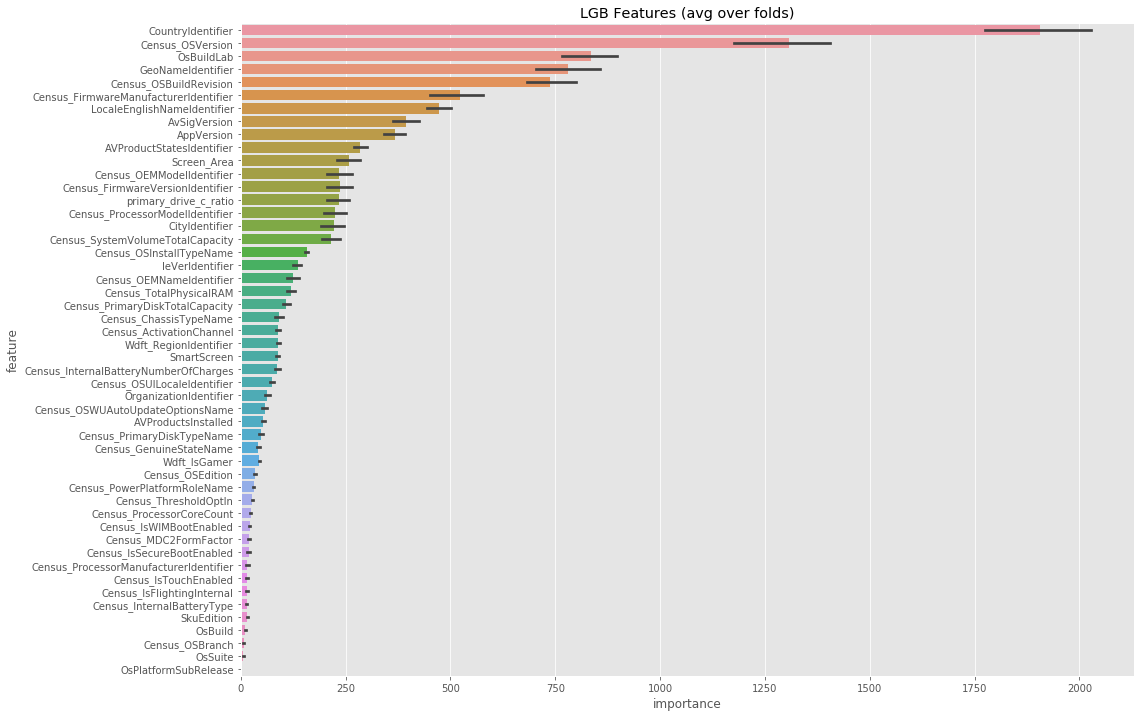

In [77]:
%%time
result_dict1 = train_model(X=x1, X_test=test, y=y1, params=params, model_type='lgb', plot_feature_importance=True, averaging='usual')

Fold 1 started at Tue Mar 12 23:52:15 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's binary_logloss: 0.620663	training's auc: 0.71123	valid_1's binary_logloss: 0.625779	valid_1's auc: 0.7031
[1000]	training's binary_logloss: 0.614609	training's auc: 0.719573	valid_1's binary_logloss: 0.623313	valid_1's auc: 0.706287
[1500]	training's binary_logloss: 0.611479	training's auc: 0.723933	valid_1's binary_logloss: 0.622892	valid_1's auc: 0.706808
Early stopping, best iteration is:
[1746]	training's binary_logloss: 0.610091	training's auc: 0.725804	valid_1's binary_logloss: 0.622728	valid_1's auc: 0.707019
Fold roc_auc: 0.7070186045875448

Fold 2 started at Wed Mar 13 00:58:48 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's binary_logloss: 0.62087	training's auc: 0.71086	valid_1's binary_logloss: 0.625513	valid_1's auc: 0.703849
[1000]	training's binary_logloss: 0.614891	training's auc: 0.719059	valid_1's binary_loglos

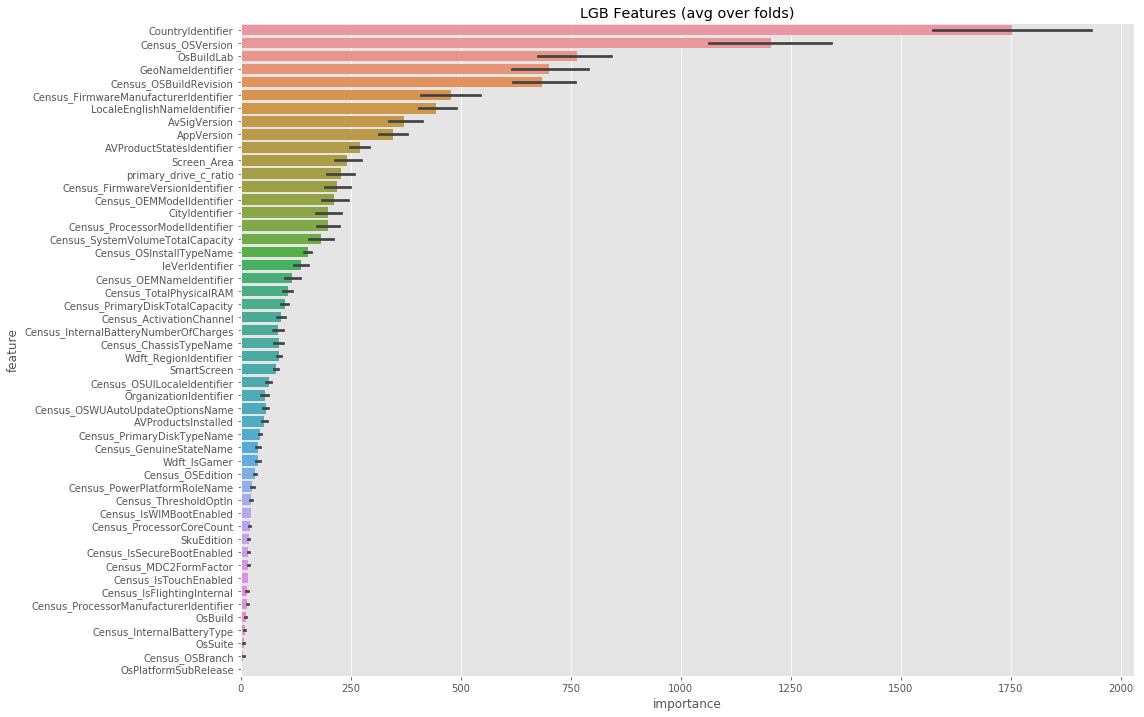

In [78]:
%%time
result_dict2 = train_model(X=x2, X_test=test, y=y2, params=params, model_type='lgb', plot_feature_importance=True, averaging='usual')

%%time
result_dict3 = train_model(X=x3, X_test=test, y=y3, params=params, model_type='lgb', plot_feature_importance=True, averaging='rank')

## Create Submission File

In [79]:
%%time
submission1 = pd.read_csv('sample_submission.csv')
submission2 = pd.read_csv('sample_submission.csv')
submissionav = pd.read_csv('sample_submission.csv')

Wall time: 1min 33s


In [80]:
%%time
submission1['HasDetections'] = result_dict1['prediction']

Wall time: 160 ms


In [81]:
%%time
submission1['HasDetections'] = result_dict2['prediction']

Wall time: 79.8 ms


In [82]:
%%time
submissionav['HasDetections'] = (result_dict1['prediction'] + result_dict2['prediction'])/2

Wall time: 168 ms


In [83]:
%%time
submission1.to_csv('submissionu1.csv', index=False)

Wall time: 31.7 s


In [84]:
%%time
submission2.to_csv('submissionu2.csv', index=False)

Wall time: 24.7 s


In [85]:
%%time
submissionav.to_csv('submissionav.csv', index=False)

Wall time: 33.5 s
